In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# Exploratory Data Analysis

In [2]:
# Load the dataset
# Source: https://www.kaggle.com/datasets/uciml/zoo-animal-classification/data
zoo_data = pd.read_csv('data/zoo.csv')

# Display the first few rows of the dataframe
print(zoo_data.head())

  animal_name  hair  feathers  eggs  milk  airborne  aquatic  predator  \
0    aardvark     1         0     0     1         0        0         1   
1    antelope     1         0     0     1         0        0         0   
2        bass     0         0     1     0         0        1         1   
3        bear     1         0     0     1         0        0         1   
4        boar     1         0     0     1         0        0         1   

   toothed  backbone  breathes  venomous  fins  legs  tail  domestic  catsize  \
0        1         1         1         0     0     4     0         0        1   
1        1         1         1         0     0     4     1         0        1   
2        1         1         0         0     1     0     1         0        0   
3        1         1         1         0     0     4     0         0        1   
4        1         1         1         0     0     4     1         0        1   

   class_type  
0           1  
1           1  
2           4  
3   

In [3]:
# Display the summary statistics of the dataframe
print(zoo_data.describe())

             hair    feathers        eggs        milk    airborne     aquatic  \
count  101.000000  101.000000  101.000000  101.000000  101.000000  101.000000   
mean     0.425743    0.198020    0.584158    0.405941    0.237624    0.356436   
std      0.496921    0.400495    0.495325    0.493522    0.427750    0.481335   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
75%      1.000000    0.000000    1.000000    1.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

         predator     toothed    backbone    breathes    venomous        fins  \
count  101.000000  101.000000  101.000000  101.000000  101.000000  101.000000   
mean     0.554455    0.603960    0.821782    0.792079    0.079208    0.168317   
std      0.499505    0.4915

In [4]:
# Display information about the dataframe including the data types of each column and memory usage
print(zoo_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal_name  101 non-null    object
 1   hair         101 non-null    int64 
 2   feathers     101 non-null    int64 
 3   eggs         101 non-null    int64 
 4   milk         101 non-null    int64 
 5   airborne     101 non-null    int64 
 6   aquatic      101 non-null    int64 
 7   predator     101 non-null    int64 
 8   toothed      101 non-null    int64 
 9   backbone     101 non-null    int64 
 10  breathes     101 non-null    int64 
 11  venomous     101 non-null    int64 
 12  fins         101 non-null    int64 
 13  legs         101 non-null    int64 
 14  tail         101 non-null    int64 
 15  domestic     101 non-null    int64 
 16  catsize      101 non-null    int64 
 17  class_type   101 non-null    int64 
dtypes: int64(17), object(1)
memory usage: 14.3+ KB
None


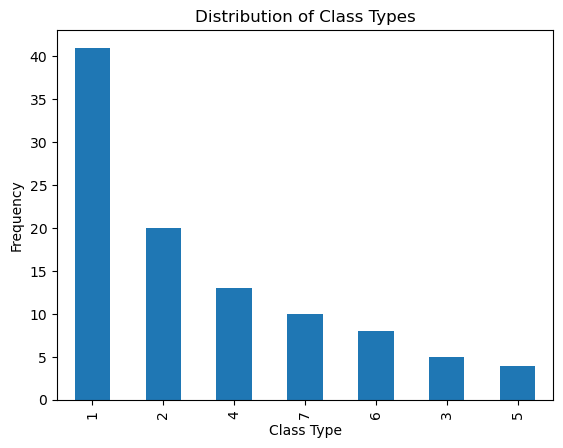

In [5]:
# Plot the distribution of the target variable 'class_type'
zoo_data['class_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Class Types')
plt.xlabel('Class Type')
plt.ylabel('Frequency')
plt.show()

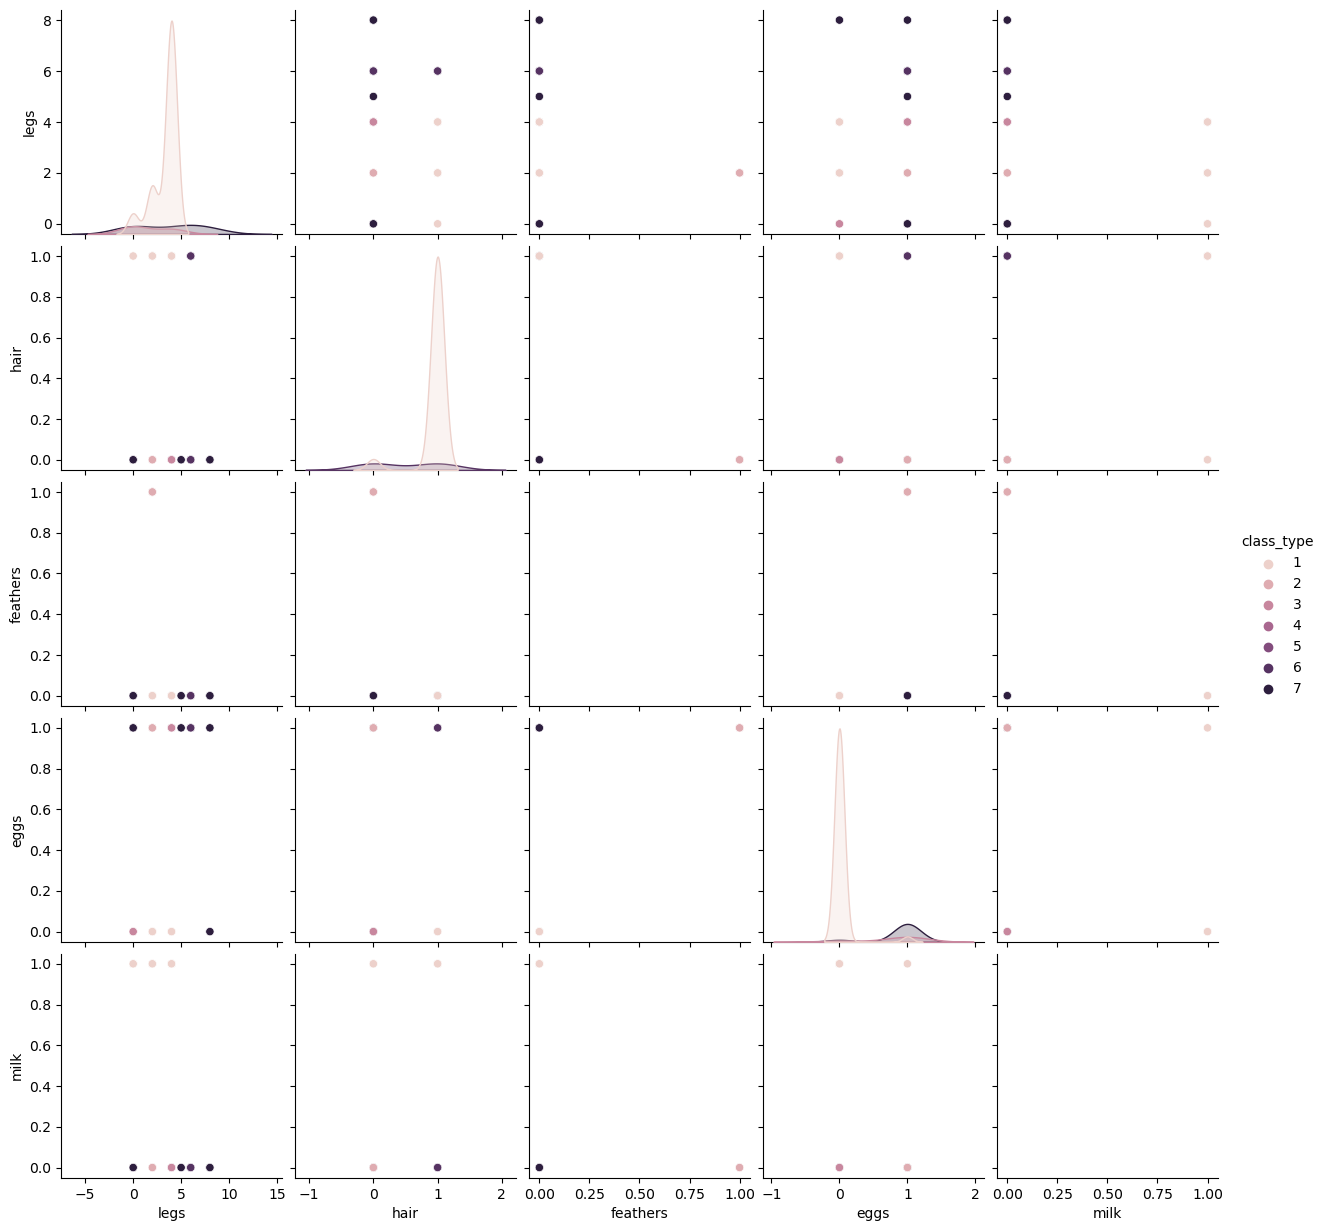

In [6]:
# Pairplot to visualize the relationships between 'legs', 'class_type' and other variables
sns.pairplot(zoo_data, hue='class_type', vars=['legs', 'hair', 'feathers', 'eggs', 'milk'])

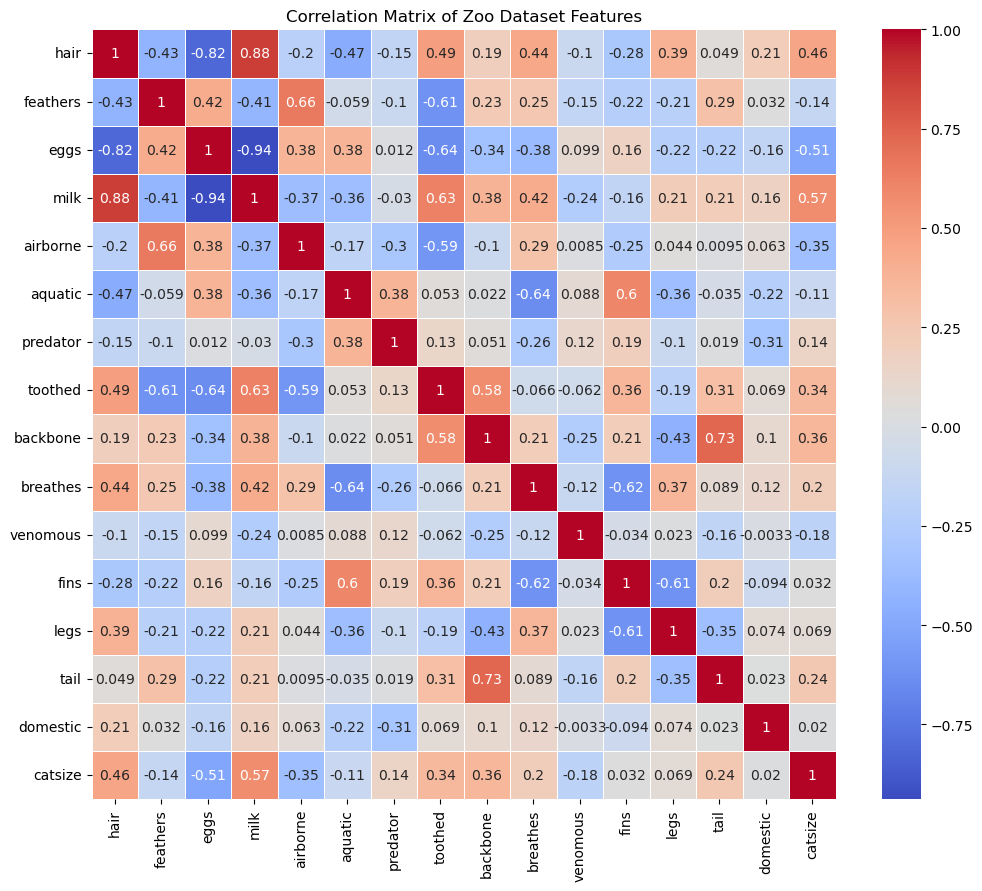

In [7]:
# Generate a correlation matrix
correlation_matrix = zoo_data.iloc[:,1:-1].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Zoo Dataset Features')
plt.show()

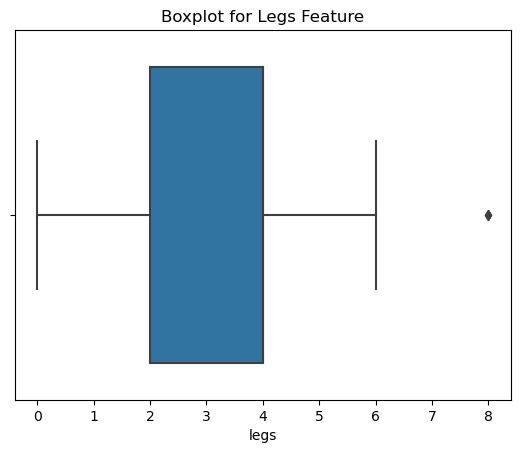

In [8]:
# Boxplot for 'legs' feature to check for outliers
sns.boxplot(x=zoo_data['legs'])
plt.title('Boxplot for Legs Feature')
plt.show()

# EDA Conclusions

1. **Class Type Distribution:** Overall, the bar chart indicates that class '1' (mammals) has more samples than others. This suggests a class imbalance, so we will have to address this in the preprocessing stage
2. **Correlation Matrix:** The heatmap of the correlation matrix shows that there are some features which show some negative correlation with one another (namely eggs and milk and eggs and hair). We have decided to not address this throughout the preprocessing stage as biologically eggs are a big marker for a lot of these classes. Moreover, even though features are correlated they might not equally contribute to the model's descision-making process, one feature may be more informative than the other even though they present correlation.
3. **Boxplot:** The graph does not show any outliers, all values fall within a reasonable range.

There are also no missing values and the data types are seemingly appropriate for each feature, which indicates overall good data quality.

-----------------------------------

# Data preprocessing

In [9]:
# No need for encoding of categorical values because there are none

In [10]:
# Step 1: Remove the 'animal_name' column and split the dataset into X and y
X = zoo_data.drop(['animal_name', 'class_type'], axis=1)
y = zoo_data['class_type']

In [11]:
# Step 2: Handling class imbalance
# Since the smallest class has 5 instances, we set k_neighbors to 4 or less
smote = SMOTE(k_neighbors=min(y.value_counts()) - 1)

# Perform the resampling
X_resampled, y_resampled = smote.fit_resample(X, y)

# Rebalanced classes
print(y_resampled.value_counts())

1    41
4    41
2    41
7    41
6    41
5    41
3    41
Name: class_type, dtype: int64


In [12]:
# Step 4: Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Model training

In [13]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Instantiate the Grid Search model
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=10,
    verbose=2,
    n_jobs=-1,
    scoring='f1_macro'
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best F1 (Macro) Score:", grid_search.best_score_)

# Get the best estimator and make predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the best model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Best F1 (Macro) Score: 0.9951020408163267
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        10

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87

Confusion Matrix:
 [[14  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 13  0]
 [ 0  0  0  0 

In [14]:
zoo_animals_rf = best_rf

with open('models/zoo_animals_rf_1.pkl','wb') as file:
    pickle.dump(zoo_animals_rf, file)